In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = gym.make("FrozenLake-v0")
transition_dict = env.env.P

gamma = 0.9

In [3]:
actions = ["Left", "Down", "Right", "Up"]
def print_policy(policy):
    print("\n Policy: \n")
    reshaped_policy = policy.reshape(4,4)
    for i in range(4):
        x = "| "
        for j in range(4):
            x += actions[int(reshaped_policy[i][j])]
            x += " | "
        print(x)

In [52]:
for rollout in range(100):
    reward = 0
    eps_length = 0
    
    env.reset()
    sample = env.action_space.sample()
    obs, rew, done, _  = env.step(sample)
    
    reward += rew
    eps_length += 1
    
    while done==False:
        sample = env.action_space.sample()
        obs, rew, done, _ = env.step(sample)
        reward += gamma**eps_length * rew
        eps_length += 1

    print(eps_length, reward)  

19 0.0
5 0.0
5 0.0
3 0.0
6 0.0
2 0.0
25 0.0
19 0.0
2 0.0
8 0.0
16 0.0
7 0.0
4 0.0
2 0.0
17 0.0
17 0.0
5 0.0
5 0.0
15 0.0
9 0.0
6 0.0
7 0.0
18 0.0
11 0.0
19 0.15009463529699918
7 0.0
9 0.0
9 0.0
11 0.0
20 0.0
4 0.0
3 0.0
2 0.0
7 0.0
7 0.0
9 0.4304672100000001
4 0.0
10 0.0
7 0.0
9 0.0
4 0.0
4 0.0
4 0.0
8 0.0
16 0.0
2 0.0
3 0.0
7 0.0
4 0.0
20 0.0
5 0.0
15 0.0
4 0.0
5 0.0
9 0.0
4 0.0
7 0.0
9 0.0
4 0.0
5 0.0
13 0.0
7 0.0
6 0.0
7 0.0
8 0.0
26 0.0
5 0.0
14 0.0
5 0.0
10 0.0
5 0.0
4 0.0
13 0.0
9 0.0
5 0.0
5 0.0
15 0.0
19 0.0
18 0.0
8 0.0
11 0.0
6 0.0
2 0.0
5 0.0
5 0.0
7 0.0
4 0.0
5 0.0
8 0.0
19 0.0
8 0.0
6 0.0
10 0.0
5 0.0
3 0.0
5 0.0
6 0.0
6 0.0
9 0.0
14 0.0


In [6]:
transition_dict[14][1]

[(0.3333333333333333, 13, 0.0, False),
 (0.3333333333333333, 14, 0.0, False),
 (0.3333333333333333, 15, 1.0, True)]

In [7]:
policy = np.random.randint(4,size=16)
print_policy(policy)        


 Policy: 

| Left | Left | Right | Up | 
| Up | Left | Down | Up | 
| Right | Left | Up | Right | 
| Right | Down | Up | Left | 


In [37]:
def r(x,a):
    x_a = np.array(transition_dict[x][a])
    r_x_a = np.dot(x_a[:,0], x_a[:,2])
    return r_x_a
def Q(x,a, V):
    x_a = np.array(transition_dict[x][a])
    return sum([ x_a[i,0]*(x_a[i,2]+gamma*V[int(x_a[i,1])]) for i in range(x_a.shape[0])])

def greedy_policy(V):
    policy = [0]*16
    for state in range(16):
        policy[state] = np.argmax(np.array([Q(state,i,V)for i in range(4)]))
    return np.array(policy).reshape(4,4)
    
greedy_policy([1]*16)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0]])

In [116]:
def bellman_optimal_update(x, V):
    potential_max = []
    for a in range(4):
        transition = np.array(transition_dict[x][a])
        rxa = 0 
        for i in range(transition.shape[0]):
            rxa += transition[i,0]*(transition[i,2] + gamma*V[int(transition[i,1])])
        potential_max += [rxa]
    return np.max(np.array(potential_max))

v = [0]*16
for iter in range(200):
    v = [bellman_optimal_update(i, v) for i in range(16)]
    #if (iter%10==0):
    #    print(f"iteration: {iter}\n Values:")
print(np.array(v).reshape(4,4))
print_policy(greedy_policy(v))

[[0.0688909  0.06141457 0.07440976 0.05580732]
 [0.09185454 0.         0.11220821 0.        ]
 [0.14543635 0.24749695 0.29961759 0.        ]
 [0.         0.3799359  0.63902015 0.        ]]

 Policy: 

| Left | Up | Left | Up | 
| Left | Left | Left | Left | 
| Up | Down | Left | Left | 
| Left | Right | Down | Left | 


In [126]:
################
#####  VI  #####
################

def bellman_optimal_update(x, V):
    potential_max = []
    for a in range(4):
        transition = np.array(transition_dict[x][a])
        rxa = 0 
        for i in range(transition.shape[0]):
            rxa += transition[i,0]*(transition[i,2] + gamma*V[int(transition[i,1])])
        potential_max += [rxa]
    return np.max(np.array(potential_max))

v = [0]*16
for iter in range(200):
    v = [bellman_optimal_update(i, v) for i in range(16)]
    #if (iter%10==0):
    #    print(f"iteration: {iter}\n Values:")
print(np.array(v).reshape(4,4))
print_policy(greedy_policy(v))

policy = np.random.randint(4,size=16)


####################################
#####   Policy Eval. + Improv. #####
####################################

def bellman_update(policy, v):
    v_up = [0]*16
    for x in range(16):
        transition = np.array(transition_dict[x][policy[x]])
        for dest in range(transition.shape[0]):
            v_up[x] += transition[dest,0]*(transition[dest,2]+gamma*v[int(transition[dest,1])])
    return v_up
    
def policy_eval(policy):
    v = [0]*16
    for i in range(100):  
        v_up = bellman_update(policy, v)
        v = v_up[:]
        #if (i%10==0):
        #    print(np.array(v).reshape(4,4))
    return v
        
        
for i in range(150):
    v = policy_eval(policy)
    policy = greedy_policy(v).flatten()


print_policy(policy)
print(np.array(policy_eval(policy)).reshape(4,4))

[[0.0688909  0.06141457 0.07440976 0.05580732]
 [0.09185454 0.         0.11220821 0.        ]
 [0.14543635 0.24749695 0.29961759 0.        ]
 [0.         0.3799359  0.63902015 0.        ]]

 Policy: 

| Left | Up | Left | Up | 
| Left | Left | Left | Left | 
| Up | Down | Left | Left | 
| Left | Right | Down | Left | 

 Policy: 

| Left | Up | Left | Up | 
| Left | Left | Left | Left | 
| Up | Down | Left | Left | 
| Left | Right | Down | Left | 
[[0.06889058 0.0614143  0.07440956 0.0558071 ]
 [0.09185425 0.         0.1122081  0.        ]
 [0.14543612 0.2474968  0.29961748 0.        ]
 [0.         0.37993579 0.63902009 0.        ]]


In [21]:
##############
# Q-Learning #
##############

q = np.zeros((16,4))

alpha = 0.1
eps = 0.1

def eps_greedy(x):
    if np.random.rand()<eps :
        return np.random.randint(0,4)
    else :
        return np.argmax(np.array([q[x,a] for a in range(4)])) 

for eps in range(150_000):
    #if eps%1000 == 0 :
    #    print(q.sum())
    env.reset()
    a = eps_greedy(0)
    obs, rew, done, _  = env.step(a)
    
    next_ = np.array([q[obs,act] for act in range(4)])
    q[0,a] = (1-alpha)*q[0,a] + alpha*(rew + gamma*np.max(next_))

    while done==False:
        a = eps_greedy(obs)
        x=obs
        obs, rew, done, _ = env.step(a)
        
        next_ = np.array([q[obs,act] for act in range(4)])
        q[x,a] = (1-alpha)*q[x,a]+ alpha*(rew + gamma*np.max(next_))

print_policy(np.array([np.argmax(q[i,:]) for i in range(16)]))


 Policy: 

| Right | Up | Left | Up | 
| Left | Left | Right | Left | 
| Up | Down | Down | Left | 
| Left | Right | Down | Left | 


In [ ]:
| Left | Up | Left | Up | 
| Left | Left | Left | Left | 
| Up | Down | Left | Left | 
| Left | Right | Down | Left | 

[[0.06889058 0.0614143  0.07440956 0.0558071 ]
 [0.09185425 0.         0.1122081  0.        ]
 [0.14543612 0.2474968  0.29961748 0.        ]
 [0.         0.37993579 0.63902009 0.        ]]


In [22]:
q

array([[0.07957435, 0.07960424, 0.08632485, 0.07621792],
       [0.05718622, 0.0699177 , 0.05922119, 0.08294745],
       [0.1204758 , 0.11195029, 0.11471109, 0.08593142],
       [0.06392437, 0.07150579, 0.0426646 , 0.08159553],
       [0.10162824, 0.08033726, 0.06548086, 0.05994997],
       [0.        , 0.        , 0.        , 0.        ],
       [0.12688099, 0.10859301, 0.16930004, 0.03618364],
       [0.        , 0.        , 0.        , 0.        ],
       [0.07088854, 0.13290854, 0.09755882, 0.15331259],
       [0.10647255, 0.27176926, 0.19690257, 0.17090155],
       [0.32109867, 0.32718107, 0.153821  , 0.15278394],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.18050765, 0.22613266, 0.39602344, 0.30806716],
       [0.38953199, 0.6248759 , 0.60233338, 0.40687949],
       [0.        , 0.        , 0.        , 0.        ]])

Text(0, 0.5, 'Values')

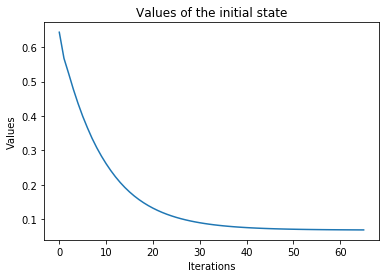

In [95]:
## V(s_0) with each step

fig, ax = plt.subplots()
plt.plot(range(len(v0)), v0)
ax.set_title("Values of the initial state")
ax.set_xlabel("Iterations")
ax.set_ylabel("Values")

### Policy iteration
1. Policy evaluation (VI for planning)
2. Policy improvement (greedy policy )

In [104]:
# Estimate values, aka, VI for PE  (Value iteration for policy improvements)
def policy_evaluation(policy, init_values, gamma, termination=1e-4):
    old_values = np.copy(values)
    max_update = 0
    # values_0 = []
    for _ in range(100):
        max_update = 0
        for i in range(16):
            values[i] = Q_x_a(old_values, i, policy[i])         
        #max_update = max(np.abs(values-old_values))
        # values_0 += [values[0]]
    return values

# update actions, Greedy strategy
def policy_improvement(values, gamma):
    # ********** TODO ***********
    policy = np.empty(16)
    for s in range(16):
            policy[s] = np.argmax([Q_x_a(values, s, a) for a in range(4)])
    return policy

In [106]:
values = np.random.rand(16)
policy = np.random.randint(4, size = (16,))

for i in range(100):
    values = policy_evaluation(policy, values, gamma, termination=1e-4)
    policy = policy_improvement(values, gamma)

print(values, "\n\n")
print_policy(policy)

[6.89106705e-02 6.14321055e-02 7.44251017e-02 5.58226313e-02
 9.18743495e-02 3.45083926e-06 1.12221379e-01 5.49469328e-06
 1.45456249e-01 2.47516965e-01 2.99636291e-01 4.00359769e-06
 1.97956935e-05 3.79957362e-01 6.39043075e-01 2.44013642e-05] 


 Left | Up | Left | Up
 Left | Left | Right | Left
 Up | Down | Left | Left
 Left | Right | Down | Left


In [102]:
print(values_, "\n\n")
print_policy(policy_)

[6.93851835e-02 6.18919889e-02 7.48687511e-02 5.62675674e-02
 9.23469693e-02 2.51287907e-04 1.12647625e-01 3.85888202e-04
 1.45925254e-01 2.47980962e-01 3.00090355e-01 2.37517568e-04
 8.30115636e-04 3.80425344e-01 6.39514364e-01 4.98642842e-04] 


 Left | Up | Left | Up
 Left | Left | Right | Left
 Up | Down | Left | Left
 Left | Right | Down | Left


### Q-learning